# Importing modules and loading csv files

In [1]:
import pandas as pd
import numpy as np
import scipy
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,Lasso,Ridge
#from sklearn.neighbors import KNeighborsRegressor, NearestNeighbors
#from sklearn.metrics import mean_squared_error
#from sklearn import preprocessing
import dask.dataframe as dd
#from sklearn.model_selection import train_test_split
#from collections import Counter
#import multiprocessing
#from itertools import combinations as comb
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# load google drive to get access to the csv files
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
# Upload manually csv files provided with this thesis
# Click on the folder icon in the upper right corner
# Then click upload and select zip file


In [3]:
!7z x csv_files.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 67511301 bytes (65 MiB)

Extracting archive: csv_files.zip
--
Path = csv_files.zip
Type = zip
Physical Size = 67511301

  0%    
Would you like to replace the existing file:
  Path:     ./csvfiles/data29001.csv
  Size:     1455779 bytes (1422 KiB)
  Modified: 2020-02-22 06:57:10
with the file from archive:
  Path:     csvfiles/data29001.csv
  Size:     1455779 bytes (1422 KiB)
  Modified: 2020-02-22 06:57:10
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? A

  0% 1 - csvfiles/data29001.csv                                 9% 5 - csvfiles/data22001.csv                               

In [5]:
# loading csv files into dataframes
df = dd.read_csv('csvfiles/data*1.csv',sep='%',dtype={'Par':'object'})
date_location = pd.read_csv('dateloc.csv',sep='%',index_col=0)
#longshortcat = pd.read_csv('drive/My Drive/Bakalarka/longshortcat.csv',sep='%', index_col=0)
#layout_data = json.load(open('drive/My Drive/Bakalarka/layout_data.json','r'))
df = df.compute()
date_location.index.name == 'Event-id'

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*(_execute_task(a, cache) for a in args))


False

#Data Cleaning

In [0]:
# Reindexing records. Run only once.
df.index = [i for i in range(len(df))]
df.drop(columns='Unnamed: 0',inplace=True)
df.index.name = 'index record'

In [0]:
# In order to transform Par column we need to replace 'E' with '0' for the conversion to work properly
df['Par'] = pd.to_numeric(df['Par'].replace(to_replace={'E':'0'}))

In [0]:
# Removing players who did not finish the tournament
df = df[df['Total']!= 'DNF']
df = df[df['Total'].notna()]

for i in range(1,11):
    df = df[df['Rd'+str(i)] != 999]
df = df[df['Semis'] != 999]
df = df[df['Finals'] != 999]

In [0]:
df['From'].fillna('',inplace=True)

In [0]:
states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

In [0]:
# Transforming tournament_location to leave only countries
for index in date_location.index:
    location = date_location.loc[index,'tournament_location']
    # ignore events with no location
    if not isinstance(location,str):
        continue

    if 'United States' in location:
        found = False
        for key,value in zip(states.keys(),states.values()):
            if (key in location) or (value in location):
                date_location.loc[index,'tournament_location'] = value+', USA'
                found = True
        if not found:
            date_location.loc[index,'tournament_location'] = ''
    else:
        date_location.loc[index,'tournament_location'] = location.split(', ')[-1].title()
    
    if len(date_location.loc[index,'tournament_location']) != 0:
        if date_location.loc[index,'tournament_location'][0]==' ':
            date_location.loc[index,'tournament_location'] = date_location.loc[index,'tournament_location'][1:]


In [13]:
# Remove events that have tournament location "All around the world" and also from the original dataframe
wrong_events = date_location[date_location['tournament_location'] == 'All Around The World'].index
print('Events that are have no set location \n',wrong_events.values)

for event in wrong_events:
    df = df[df['Event-id'] != event]

date_location = date_location[date_location['tournament_location'] != 'All Around The World']

Events that are have no set location 
 [13184 16706 22278 36279 43587]


In [0]:
def change_country(country_string):
    if not isinstance(country_string, str):
        return ''
    for item, value in states.items():
        if item in country_string or value in country_string:
            return value+', USA'
    if 'Armed Forces' in country_string:
        return country_string
    return country_string.split(',')[-1].strip()

df['From'] = df.From.apply(change_country)

In [0]:
# Events that need to be removed, due to published unofficial results
discard_events = [1702, 1716, 14303, 37873, 38091, 41702, 37645, 41888, 37564]
for event in discard_events:
    df = df[df['Event-id'] != event]

In [0]:
date_location = date_location.loc[date_location.index<=43000]

In [0]:
df['Year'] = pd.to_numeric(df['Event-id'].apply(lambda x: date_location.loc[x,'tournament_date'][-4:]))

# Exploratory Data Analysis




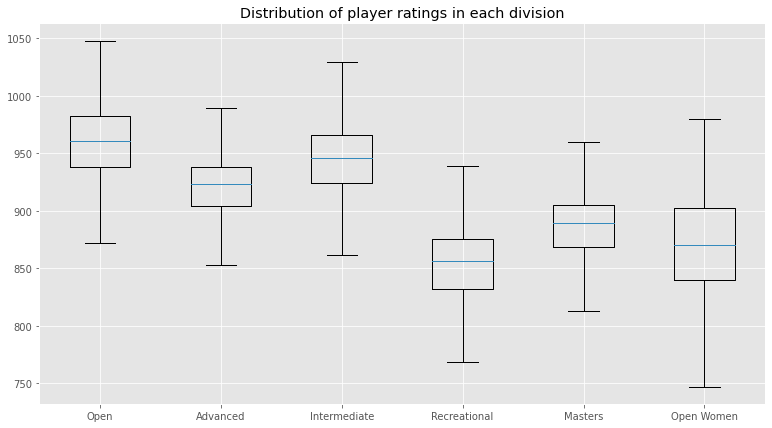

In [0]:
# Before plotting a boxplot we need to clean nan values
d1 = df[(df['Category']=='Open') & (df['Propagator']==True)]['Rating'].dropna()
d2 = df[(df['Category']=='Advanced')& (df['Propagator']==True)]['Rating'].dropna()
d3 = df[(df['Category']=='Intermediate')& (df['Propagator']==True)]['Rating'].dropna()
d4 = df[(df['Category']=='Recreational')& (df['Propagator']==True)]['Rating'].dropna()
d5 = df[(df['Category']=='Masters')& (df['Propagator']==True)]['Rating'].dropna()
d6 = df[(df['Category']=='Open Women')& (df['Propagator']==True)]['Rating'].dropna()

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [13,7]
plt.boxplot([d1, d2, d5, d4, d3, d6],labels=['Open','Advanced','Intermediate','Recreational','Masters','Open Women'], showfliers=False)
plt.title('Distribution of player ratings in each division')
plt.show()

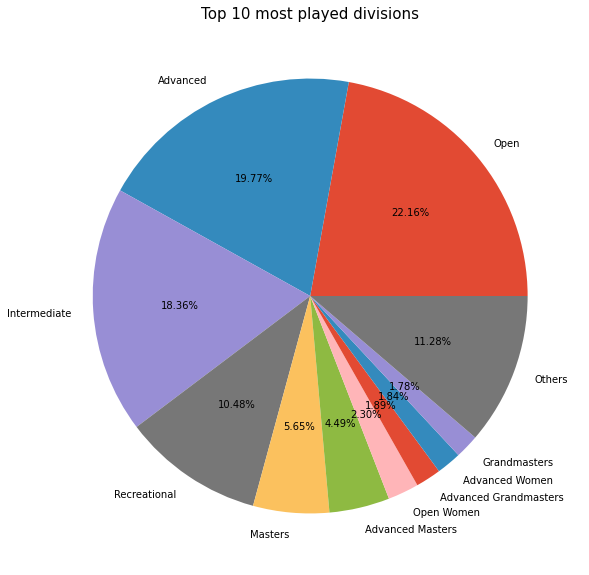

In [0]:
# Visualize most played divisions
topten = (df.groupby('Category')['Name'].count().sort_values(ascending=False)/df['Name'].count())[:10]
topten['Others'] = 1-np.sum(topten.values)
plt.rcParams['figure.figsize'] = [13,10]
plt.pie(topten.values, labels=topten.index, autopct='%1.2f%%')
plt.title('Top 10 most played divisions', fontdict={'fontsize':15})
plt.savefig('top10div.png')
plt.show()

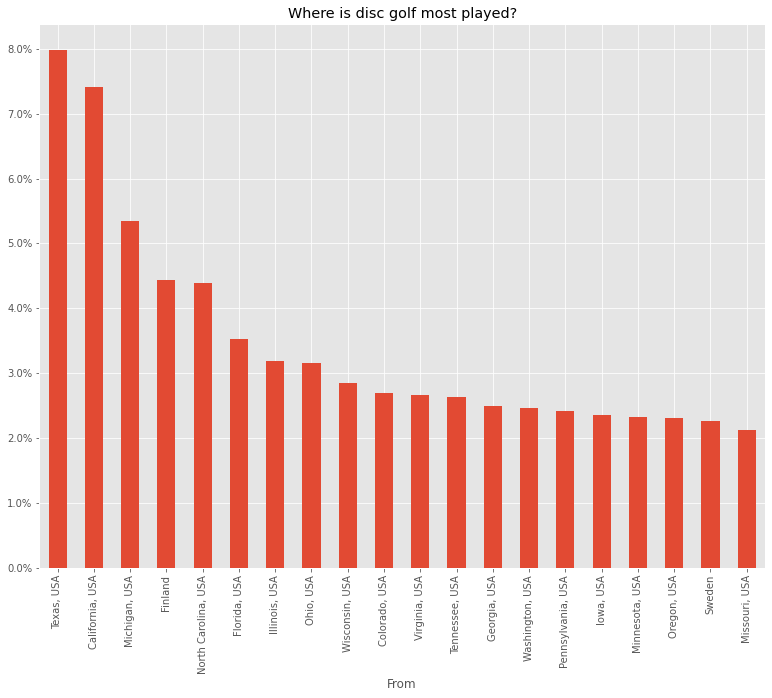

In [0]:
# Percentage of disc golf activity in a given country, ranked by country
import matplotlib.ticker as mtick
ax = ((df.groupby('From')['PDGA#'].count().sort_values(ascending=False)/df['PDGA#'].count())[:20].round(4)*100).plot(kind='bar', title='Where is disc golf most played?')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

#Helper functions

In [0]:
def plot_event(event, x, y, rr=None, plot_model=False, savefig=False):
    '''General ploting function:
    Params:
        event (int): tournamaned event id
        x (string): what to apppear on the x-axis can be Rating, Rd1, RR1 or any numeric column in the dataframe
        y (string): the same as x but on the y-axis
        plot_model (bool): whether to plot linear regression model onto a graph
        plot_nonprops(bool): whether to include people who are not propagators in the scatterplot'''
    plt.rcParams['figure.figsize'] = [12,7]
    if rr == None:
        prop = df[(df['Event-id']==event) & (df['Propagator']==True)][[x,y,'Category']].dropna(axis=0)
    else:
        prop = df[(df['Event-id']==event) & (df['Propagator']==True)][[x,y,rr,'Category']].dropna(axis=0)

    for name,group in prop.groupby('Category'):
        plt.scatter(group[x],group[y],label=name)
    if rr != None:
        plt.scatter(prop[rr], prop[y], label='Round ratings', marker='s')
    plt.title(f'Event {event} {x}')
    plt.xlabel(x)
    if 'Rd' in y:
       plt.ylabel(f'Round {y[-1]} score')

    if plot_model:
        lin_model = LinearRegression()
        lin_model.fit(prop[x].values.reshape(-1,1),prop[y])

        minval = prop[x].min()
        maxval = prop[x].max()
        plotx = np.linspace(minval-20,maxval+20)
        
        plt.text(plotx[25], min(lin_model.predict(plotx.reshape(-1,1))), 
                 'Regression slope:'+str(lin_model.coef_).strip('[').strip(']'))
        plt.plot(plotx,lin_model.predict(plotx.reshape(-1,1)), label='Regression Line through propagators')
    
    plt.legend()
    if savefig:
        plt.savefig(f'{event}.png')

In [0]:
def get_tournaments(a,b):
    '''Get tournaments that happenened in (a,b) year range'''
    date = pd.to_numeric(date_location['tournament_date'].apply(lambda x: x[-4:]))
    return date_location.loc[date.between(a,b)]

In [0]:
def remove_outliers(dataframe,columns=['all'], remove=True):
    '''Removes outliers on the entire dataframe, unless specific columns specified. 
    Outliers will be removed or returned based on 'remove' boolean.'''
    dataframe = dataframe.copy()
    if columns == ['all']:
        columns = dataframe.columns
    for column in columns:
        q3 = dataframe[column].quantile(0.75)
        q1 = dataframe[column].quantile(0.25)
        iqr = q3-q1
        lower_bound = q1-1.5*iqr
        upper_bound = q3+1.5*iqr
        if remove:
            dataframe = dataframe[(dataframe[column]>lower_bound) & (dataframe[column]<upper_bound)]
        else:
            dataframe = dataframe[~((dataframe[column]>lower_bound) & (dataframe[column]<upper_bound))]
    return dataframe

In [0]:
def feature_normalization(dataframe, copy=True):
    '''Subrating the mean for each column and dividing it by it's own standard deviation'''
    if copy:
        dataframe = dataframe.copy()
    for column in dataframe.columns:
        u = dataframe[column].mean()
        s = dataframe[column].std()
        dataframe[column] = (dataframe[column]-u)/s
    return dataframe
    
def adjusted_r2(r2, n ,f):
    '''Returns r^2 deflated by numer of parameters in linear regression
    r2 is normal r squared
    n is numer of data points
    f degrees of freedom, number of parameters in the linear model'''
    
    return 1-(1-r2)*(n-1)/(n-f-1)

# Gain/lost points at the tournament

In [0]:
# This takes a long time to run. Load the complete file in the next cell.

#For each tournament calculate AVG(AVG(RR1 + RR2 + RR3+ ... +RR10) - Rating)
# Missing values are not counted
gainlose = pd.DataFrame(columns=['gained per player','variance of gained points', 'median of gained points', 'country','# of propagators','year'])
gainlose.index.name = 'Event-id'
for event in df['Event-id'].unique():
    print(event)
    RR = [f'RR{i}' for i in range(1,11)]
    data = df[(df['Event-id']==event) & (df['Propagator']==True)][['Rating']+RR]
    mean_after = data[RR].mean(axis=1)
    gained = (mean_after-data['Rating']).mean()
    var = (mean_after-data['Rating']).var()
    median = (mean_after-data['Rating']).median()
    gainlose.loc[event]=[gained, var, median, date_location.loc[event,'tournament_location'],
                         len(data), date_location.loc[event,'tournament_date'][-4:]]
gainlose.to_csv('gainlose.csv',sep='%')

In [0]:
# Load already finished file
gainlose = pd.read_csv('gainlose.csv',sep='%',index_col=0)

In [0]:
# Drop events with less than 5 propagators
gainlose = gainlose[gainlose['# of propagators']>=5]

# Wrongly scraped tournament countries
gainlose.loc[39650,'country'] = 'Arkansas, USA'
gainlose.loc[41577,'country'] = 'Colorado, USA'

gainlose['# of propagators'] = pd.to_numeric(gainlose['# of propagators'], errors='coerce')
gainlose['year'] = pd.to_numeric(gainlose['year'], errors='coerce', downcast='integer')

In [24]:
# sorted by gained per mean
gainlose[gainlose['gained per player'].notna()].sort_values(by='gained per player')

,gained per player,variance of gained points,median of gained points,country,# of propagators,year
Event-id,,,,,,
32639,-67.700000,31953.325000,6.500000,"Minnesota, USA",5,2017
21009,-47.750000,7698.250000,-28.500000,"Washington, USA",28,2015
19817,-40.534483,647.427340,-42.000000,"Michigan, USA",29,2015
5090,-39.933333,925.476543,-38.833333,Japan,10,2005
11001,-38.800000,6815.677778,-6.250000,"West Virginia, USA",10,2010
...,...,...,...,...,...,...
40710,58.166667,2089.666667,58.750000,Finland,6,2019
37723,58.846154,2042.807692,59.000000,Finland,13,2018
6133,64.900000,371.425000,65.500000,Australia,5,2006


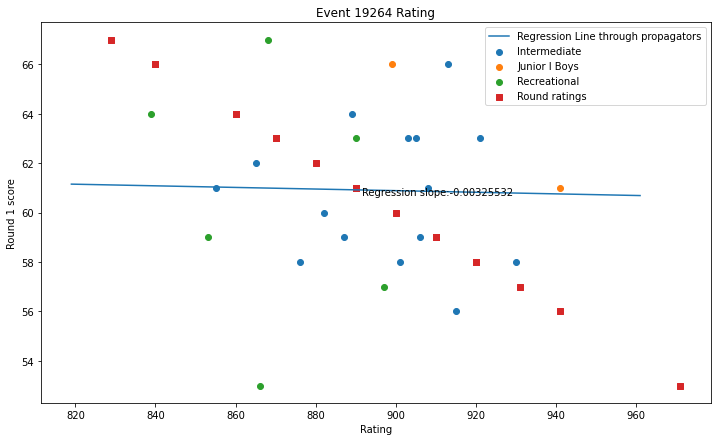

In [0]:
plot_event(19264, 'Rating','Rd1', 'RR1',plot_model=True, savefig=True)

# Data Analysis


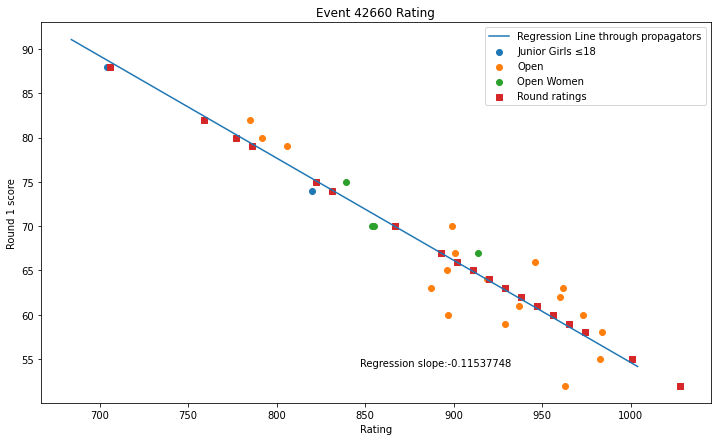

In [0]:
plot_event(42660,'Rating','Rd1', 'RR1',plot_model=True, savefig=True)

Text(0, 0.5, '# of tournaments')

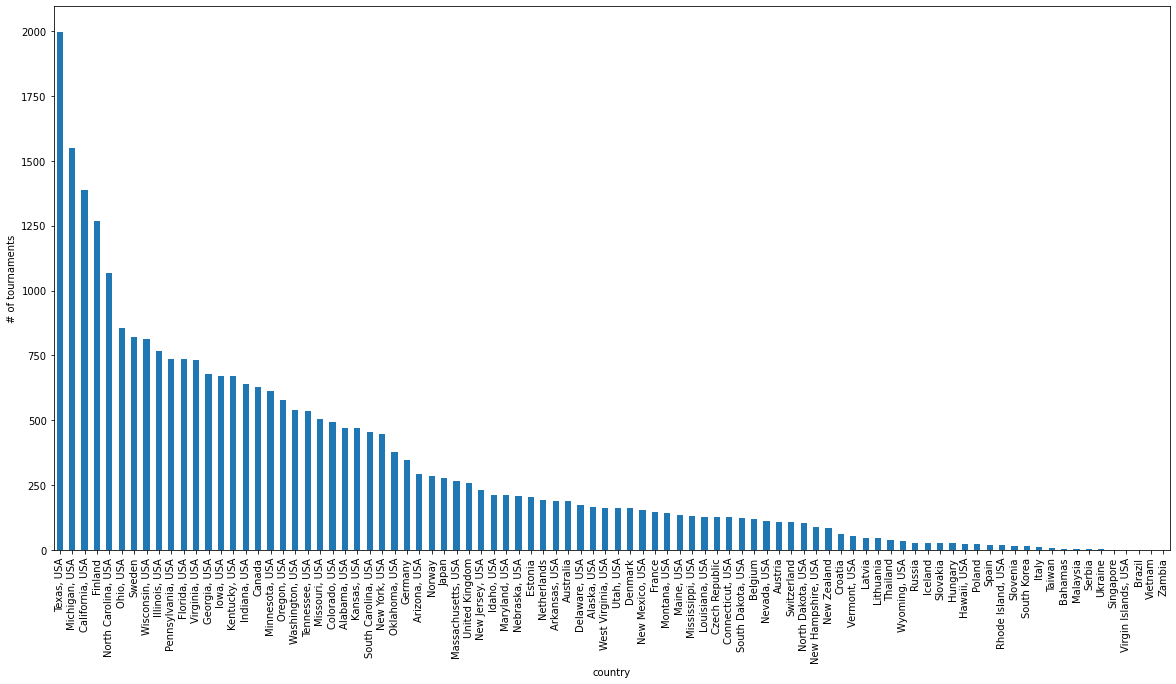

In [25]:
# number of tournaments in that country 
select_tournaments = get_tournaments(1998,2019).index
gainlose_selected = gainlose.reindex(select_tournaments).dropna(how='all', axis=0)
number_of_tournaments  = gainlose_selected.groupby('country')['gained per player'].count().sort_values(ascending=False) 
ax = number_of_tournaments.plot(kind='bar', figsize=(20,10))
ax.set_ylabel('# of tournaments')

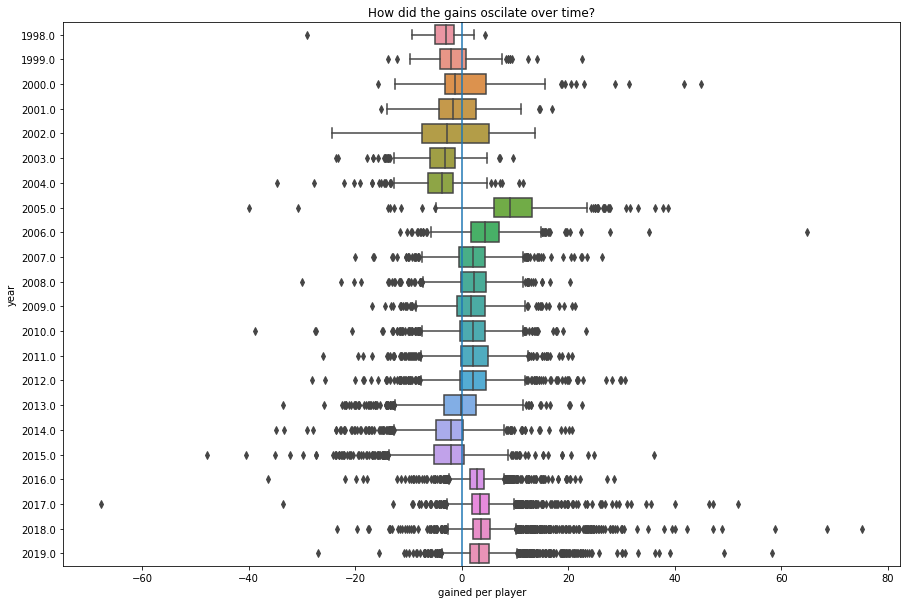

In [27]:
# Boxplot of gains by each year
period_data = gainlose.reindex(get_tournaments(1998,2019).index).dropna(how='all',axis=0).dropna()
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(y='year', x='gained per player', data=period_data, orient='h', ax=ax)
ax.axvline(0)
plt.title('How did the gains oscilate over time?')
plt.savefig('boxplot by the years.png')

In [0]:
# Trasported Ratings MATRIX. 
#Only propagators are counted
# A[i,j] describes how many rating points were given from country i to country j
# This takes a long time to process, you can just run the next cell to load it from a finished csv file

transfer_matrix = pd.DataFrame(columns=date_location['tournament_location'].unique())
for index in df['From'].unique():
    for column in transfer_matrix.columns:
        transfer_matrix.loc[index, column] = 0

for index,row in df[df['Propagator']==True].iterrows():
    print(index)
    event_location = date_location.loc[row['Event-id'],'tournament_location']
    rating_after = row[[f'RR{i}' for i in range(1,11)]].mean()
    if np.isnan(row['Rating']) or np.isnan(rating_after):
        continue
    transfer_matrix.loc[row['From'], event_location] +=  rating_after - row['Rating']

transfer_matrix.to_csv('transfer_matrix.csv',sep='%')

In [0]:
def convert_division(division, to_short:True):
    '''Convert long string of discgolf division into short. Can be reversed if 
    Example Open ---> MPO
    Params:
        division (str): division string to convert
        to_short (bool): whether to convert it in short or long format'''
    try:
        if to_short:
            return longshortcat[longshortcat['long']==division]['short'].values[0]
        else:
            return longshortcat[longshortcat['short']==division]['long'].values[0]
    except:
        return ''

In [0]:
# time intervals [a, b]
period1 = (1998,2005)
period2 = (2006,2010)
period3 = (2011,2015)
period4 = (2016,2021)

#modeldata


In [0]:
modeldata = pd.DataFrame(columns=['r2', 'intercept', 'slope', 'gained mean', 'gained std', 'gained median', '# props'])

for name,group in df.groupby('Event-id'):
    print(name)
    RR = [f'RR{i}' for i in range(1,11)]
    for i in range(1,11):
        if group['RR'+str(i)].isna().all():
            continue
        x = 'Rating'
        y = 'Rd'+str(i)
        data = group[group['Propagator']==True][[x,y]].dropna()
        if len(data)<5:
            continue
        before_rating = data[x]
        round_score = data[y]

        after_rating = group['RR'+str(i)]
        gained_mean = (after_rating-before_rating).mean()
        gained_std = (after_rating-before_rating).std()
        gained_median = (after_rating-before_rating).median()
        linmodel = LinearRegression()
        linmodel.fit(before_rating.values.reshape(-1,1), round_score)
        r2 = linmodel.score(before_rating.values.reshape(-1,1), round_score)  
        numofprops = len(data)
        modeldata.loc[str(name)+'RR'+str(i)] = [r2, linmodel.intercept_, linmodel.coef_[0], 
                                                gained_mean, gained_std, gained_median, numofprops]
modeldata.to_csv('modeldata.csv',sep='%')

In [0]:
# load modeldata from uploaded file
modeldata = pd.read_csv('modeldata.csv',sep='%',index_col=0)

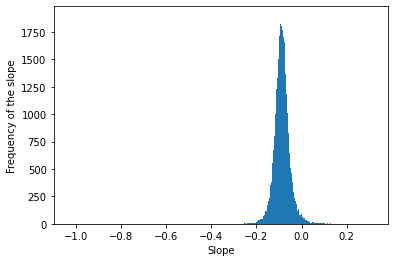

In [0]:
plt.hist(modeldata['slope'], bins='fd')
plt.xlabel('Slope')
plt.ylabel('Frequency of the slope')
plt.savefig('slope_distribution.png')
plt.show()

67373


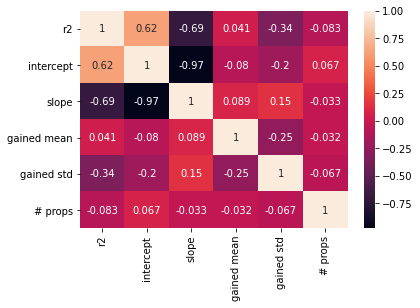

In [0]:
sns.heatmap(modeldata.corr(),annot=True)
print(len(modeldata))


# Transfer matrix


In [0]:
# TRAVEL MATRIX. 
# A[i,j] describes how many times players from a country i played a tournament in a country j
travel_matrix = pd.DataFrame(columns=date_location['tournament_location'].unique())
for index in df['From'].unique():
    for column in travel_matrix.columns:
        travel_matrix.loc[index, column] = 0

for index,row in df.iterrows():
    print(index)
    event_location = date_location.loc[row['Event-id'],'tournament_location']
    travel_matrix.loc[row['From'], event_location] += 1

travel_matrix.to_csv('travel_matrix.csv',sep='%')

In [0]:
# Load travel matrix from google drive
travel_matrix = pd.read_csv('drive/My Drive/Bakalarka/travel_matrix.csv',sep='%')

Text(0, 0.5, 'Number of times slovaks played a tournament in that country')

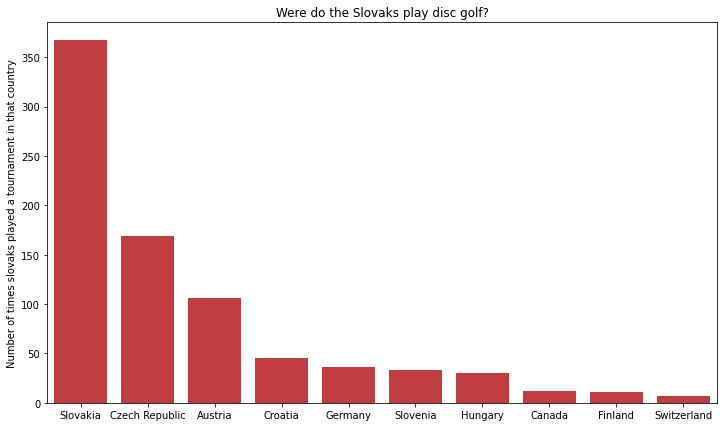

In [0]:
title = 'Where do the Slovaks play disc golf?'
ylabel = '# of times Slovakian players played tournament in that country'

top10 = travel_matrix.loc['Slovakia'].sort_values(ascending=False)[:10]
ax = sns.barplot(x=top10.index,y = top10.values, color='tab:red')
ax.set_title('Were do the Slovaks play disc golf?')
ax.set_ylabel('Number of times Slovak played a tournament in that country')

Text(0, 0.5, 'Number of times people in that country played a tournament in Slovakia')

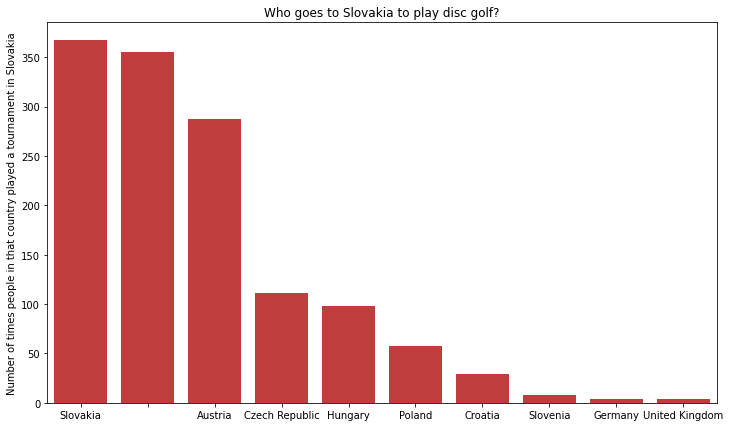

In [0]:
top10 = travel_matrix['Slovakia'].sort_values(ascending=False)[:10]
ax = sns.barplot(x=top10.index,y = top10.values, color='tab:red')
ax.set_title('Who goes to Slovakia to play disc golf?')
ax.set_ylabel('Number of times people in that country played a tournament in Slovakia')

# Regularization


In [0]:
c = [0.01, 0.1, 1, 3, 10,100, 1000]
regularized = pd.DataFrame(columns = ['intercept', 'slope', 'predicted gained mean', 'best c', 'gained mean'])
for event, group in df.groupby('Event-id'):
    print(event)
    if np.random.randint(4)!=2:
        continue
    data = group[(group['Propagator']==True)][['Rating','Rd1','RR1']].dropna()
    y = data['Rating'].values
    x = data['Rd1'].values
    m = len(data)
    if m<5:
        continue

    def cost_fun(beta, alpha):
        J = 1/(m) * ((y - beta[0] - beta[1]*x)**2).sum() + alpha*abs(0.1-beta[1])**2
        return J

    x0 = np.ones(shape=(2,1))*0.15

    what_c = []
    for i in c:
        result = scipy.optimize.minimize(cost_fun, x0, args=(i,))
        beta_opt = result.x
        predicted = beta_opt[0] + beta_opt[1] * x
        gained_mean = (predicted - y).mean()
        what_c.append(gained_mean)
    
    best_c = what_c.index(min(what_c))
    result = scipy.optimize.minimize(cost_fun, x0, args=(c[best_c],))
    beta_opt = result.x
    predicted = beta_opt[0] + beta_opt[1] * x
    pred_gained_mean = (predicted - y).mean()
    gained_mean = (data['RR1'] - data['Rating']).mean()
    regularized.loc[event] = [beta_opt[0], beta_opt[1], pred_gained_mean, c[best_c], gained_mean] 


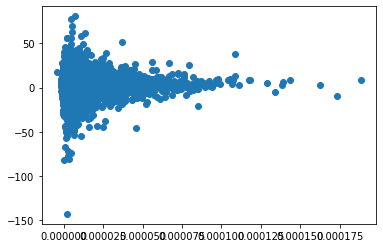

In [0]:
plt.scatter(regularized['predicted gained mean'],regularized['gained mean'])

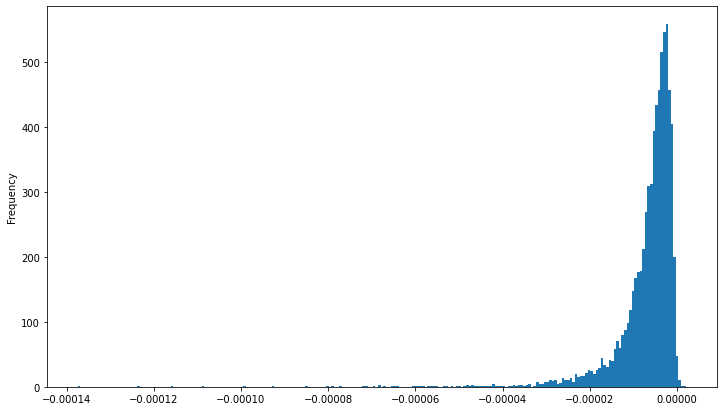

In [0]:
regularized['predicted gained mean'].plot(kind='hist',bins='fd', figsize=(12,7))
plt.savefig('regularization.png')

In [0]:
regularized.dtypes

intercept                float64
slope                    float64
predicted gained mean    float64
best c                   float64
gained mean              float64
dtype: object

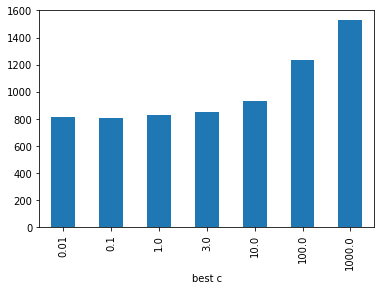

In [0]:
regularized.groupby('best c')['slope'].count().plot(kind='bar')
plt.savefig('c.png')

#Transfer matrix

In [0]:
#Trasported Ratings MATRIX. 
#Only propagators are counted
# A[i,j] describes how many rating points were given from country i to country j
# This takes a long time to process, you can just run the next cell to load it from a finished csv file

transfer_matrix = pd.DataFrame(columns=date_location['tournament_location'].unique())
for index in df['From'].unique():
    for column in transfer_matrix.columns:
        transfer_matrix.loc[index, column] = 0

for index,row in df[df['Propagator']==True].iterrows():
    print(index)
    event_location = date_location.loc[row['Event-id'],'tournament_location']
    rating_after = row[[f'RR{i}' for i in range(1,11)]].mean()
    if np.isnan(row['Rating']) or np.isnan(rating_after):
        continue
    transfer_matrix.loc[row['From'], event_location] +=  rating_after - row['Rating']

transfer_matrix.to_csv('transfer_matrix.csv',sep='%')

In [0]:
# Load from google drive
transfer_matrix = pd.read_csv('drive/My Drive/Bakalarka/transfer_matrix.csv', sep='%', index_col=0)

In [0]:
transfer_matrix

,"Pennsylvania, USA","Oklahoma, USA","Maryland, USA","North Carolina, USA","Iowa, USA","Texas, USA","Arizona, USA","Delaware, USA","Oregon, USA","Tennessee, USA","Indiana, USA","Georgia, USA","Minnesota, USA","Kentucky, USA","Arkansas, USA","Louisiana, USA","California, USA","Nevada, USA","Kansas, USA","Michigan, USA","Florida, USA","Wisconsin, USA","Ohio, USA",Canada,"New Jersey, USA","Colorado, USA","Washington, USA","Illinois, USA","New Mexico, USA",Unnamed: 30,"Alabama, USA","South Carolina, USA",Sweden,"Missouri, USA","New York, USA","Virginia, USA","North Dakota, USA","Nebraska, USA",Japan,"Hawaii, USA",...,France,Netherlands,Switzerland,Bahamas,"Vermont, USA",Russia,"New Hampshire, USA",Egypt,Austria,Italy,Thailand,Hungary,Lithuania,Latvia,Estonia,Israel,Czech Republic,South Korea,Slovakia,Spain,Croatia,"Virgin Islands, USA",Costa Rica,Slovenia,Poland,Brazil,Ethiopia,Serbia,Ukraine,Zambia,China,Singapore,Malaysia,"National, USA",Vietnam,Mexico,Ireland,"Northern Mariana Islands, USA",Cambodia,Afghanistan
"Pennsylvania, USA",56088.08,-77.00,1110.50,-1590.08,-303.45,378.08,-421.65,4374.08,-307.14,-239.16,86.96,-234.14,-59.50,-640.33,-66.33,-9.00,-111.63,128.17,-1722.24,-1745.52,-104.80,-376.50,-3073.96,-244.75,-920.92,235.67,184.33,-380.02,-163.83,0.00,-189.30,-752.67,0.00,76.24,-723.72,-2092.73,0.00,-15.50,-22.00,15.67,...,0.00,0.00,0.00,80.00,-477.97,0.00,-76.33,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-51.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0
NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34.00,0.00,51.42,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.71,0.00,0.00,0.00,0.00,-115.83,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,94.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-12.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,27.50,4.50,0.00,0.00,0.00,0.00,0,0,0
"New York, USA",62.10,-13.15,-89.17,-234.86,-145.90,304.92,-101.82,322.33,-85.96,-75.43,162.12,250.63,-71.83,-307.83,-60.83,21.42,-412.38,-95.00,-2995.34,-818.36,-257.08,-862.57,-1901.27,-1379.67,2192.42,1399.92,183.50,-48.42,43.83,0.00,-155.60,-560.92,2.00,-258.30,30128.08,347.50,0.00,0.00,-38.20,0.00,...,0.00,0.00,30.33,0.00,-240.23,0.00,-150.00,0,0.00,0.00,0.00,0.00,-43.33,0.00,0.00,0.00,2.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0
"Ohio, USA",4430.40,43.75,-91.00,-419.67,-179.03,-293.30,-356.45,29.17,18.08,206.39,-2012.49,127.83,200.65,-698.67,56.67,-6.50,-147.92,-112.58,748.02,-1217.93,612.50,1.00,56247.14,-118.58,-77.25,-67.85,422.50,520.38,-14.50,8.00,-82.77,-143.17,0.00,334.60,-15.39,292.17,0.00,0.00,-76.20,-67.50,...,-5.00,0.00,0.00,-8.00,69.30,0.00,1.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-5.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0
Austria,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-325.00,0.00,0.00,0.00,0.00,0.00,-34.00,0.00,0.00,0.00,-32.50,0.00,0.00,0.00,0.00,0.00,0.00,22.86,0.00,0.00,0.00,0.00,-155.78,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-24.22,152.00,-117.75,0.00,0.00,0.00,0.00,0,7656.05,70.75,-84.17,342.00,0.00,0.00,-66.67,0.00,-797.00,0.00,-309.13,-44.33,-583.58,0.00,0.00,397.50,-32.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zambia,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

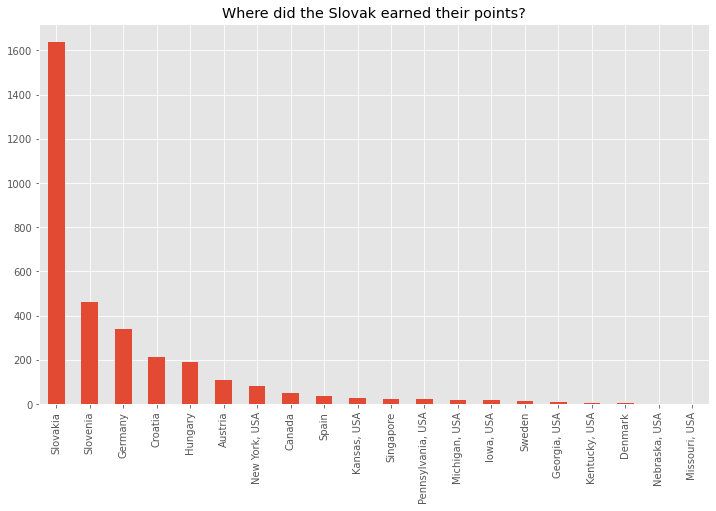

In [0]:
transfer_matrix.loc['Slovakia'].sort_values(ascending=False)[:20].plot(kind='bar', title='Where did the Slovak earned their points?')

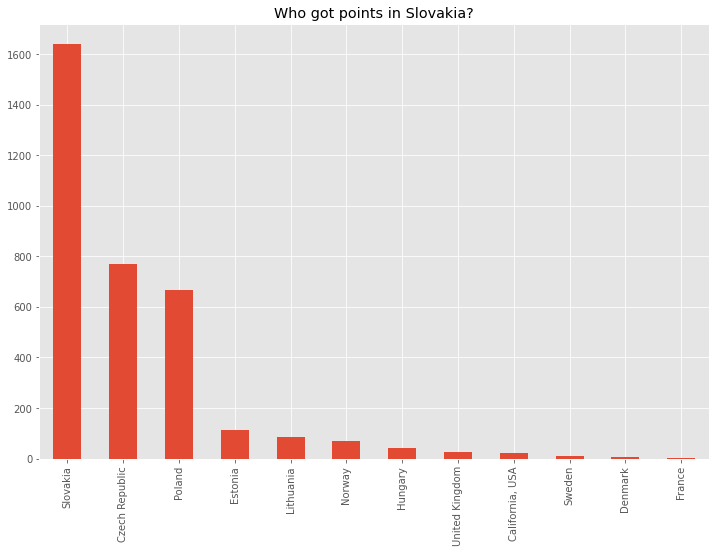

In [0]:
transfer_matrix['Slovakia'].sort_values(ascending=False)[:12].plot(kind='bar', title='Who got points in Slovakia?')